In [1]:
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyranges as pr

## Read in ref and non-ref insertions

In [5]:
# read the rmsk file
rmsk = pd.read_csv(
    # snakemake.input.rmsk[0],
     "/raidixshare_logg01/mcuoco/internal/BSMN/resources/hs38DH/hs38DH.fa.out",
    skiprows=3,
    delim_whitespace=True,
    names=["Chromosome", "Start", "End", "Strand", "repeat"],
    usecols=[4, 5, 6, 8, 9],
)
# filter for rep_names
rep_names = [
    "L1HS_3end",
    "L1PA2_3end",
    "L1PA3_3end",
    "L1PA4_3end",
    "L1PA5_3end",
    "L1PA6_3end",
]
rmsk = rmsk[rmsk["repeat"].isin(rep_names)]
rmsk["Strand"] = rmsk.apply(lambda x: "+" if x.Strand == "+" else "-", axis=1)
rmsk = pr.PyRanges(rmsk)

In [6]:
knrgl = pd.read_csv(
    # snakemake.input.knrgl[0],
    "/raidixshare_logg01/mcuoco/internal/BSMN/resources/LIBD74/hs38DH_insertions.bed",
    sep="\t",
    header=None,
    names=["Chromosome", "Start", "End", "Strand", "SVLEN", "SVTYPE"],
    dtype={"Chromosome": str, "Start": int, "End": int},
)
knrgl["Start"] = knrgl.apply(
    lambda x: x.Start - 750 if x.Strand == "-" else x.Start, axis=1
)
knrgl["End"] = knrgl.apply(lambda x: x.End + 750 if x.Strand == "+" else x.End, axis=1)
knrgl = pr.PyRanges(knrgl)

## Find peaks

In [96]:
# fn = "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/bulk/gDNA_usd2.bam"
fn = "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/mda/usd02_A2_S128.bam"

In [97]:
# STEP 1: make peaks from highest quality read1 alignments
# bam = pysam.AlignmentFile(snakemake.input.bam, "rb")  # must be coordinate sorted
bam = pysam.AlignmentFile(fn, "rb")  # must be coordinate sorted
reads = {"Chromosome": [], "Start": [], "End": [], "Strand": [], "YA": [], "YG": []}
print("Making non-ref L1 peaks from high-quality R1 reads...")
for r in bam.fetch():

    # make peaks from read1 if
    # 1. is a read1 primary alignment
    # 2. mate aligns better to L1 than reference genome (YA >20, YA>YG)
    # 3. has high mapping quality (60), indicating it's uniquely mapped
    if (
        r.is_read1
        and (not r.is_unmapped)
        and (not r.is_secondary)
        and (not r.is_supplementary)
        and (not r.has_tag("XA")) 	
        and (not r.has_tag("SA"))
        and (r.has_tag("YA") and r.has_tag("YG"))
        and (r.get_tag("YA") > 20 and r.get_tag("YA") > r.get_tag("YG"))
        and (r.mapping_quality >= 60)
    ):
        reads["Chromosome"].append(r.reference_name)
        reads["Start"].append(r.reference_start - 750 + r.query_length if r.is_reverse else r.reference_start)
        reads["Start"][-1] = 0 if reads["Start"][-1] < 0 else reads["Start"][-1]
        reads["End"].append(r.reference_end if r.is_reverse else r.reference_end + 750 - r.query_length)
        reads["Strand"].append("-" if r.is_reverse else "+")
        reads["YA"].append(r.get_tag("YA"))
        reads["YG"].append(r.get_tag("YG"))

bam.close()
p = pd.DataFrame.from_records(reads)
p["width"] = p["End"] - p["Start"]
p = pr.PyRanges(p)
print(f"Found {len(p)} reads")

Making non-ref L1 peaks from high-quality R1 reads...
Found 179631 reads


[None]

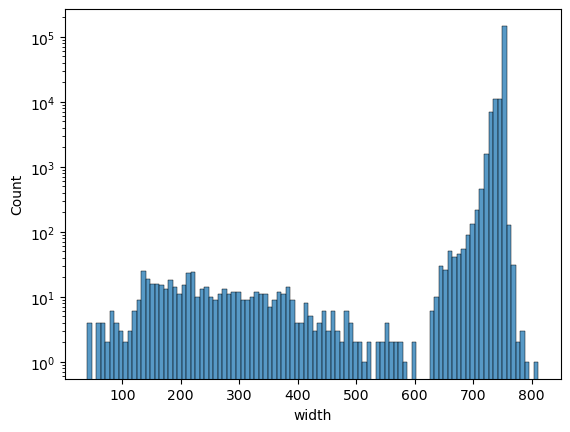

In [98]:
fig = sns.histplot(data=p.df, x="width", bins=100)
fig.set(yscale="log")

In [99]:
clu = p.cluster(strand=True, count=True).as_df()
peaks = {"Chromosome": [], "Start": [], "End": [], "Strand": [], "Cluster": [], "nreads": []}
for c in clu.itertuples():
	if len(peaks["Chromosome"]) == 0:
		peaks["Chromosome"].append(c.Chromosome)
		peaks["Start"].append(c.Start)
		peaks["End"].append(c.End)
		peaks["Strand"].append(c.Strand)
		peaks["Cluster"].append(c.Cluster)
		peaks["nreads"].append(c.Count)
	elif (c.Cluster == peaks["Cluster"][-1]):
		peaks["End"][-1] = c.End
	else:
		peaks["Chromosome"].append(c.Chromosome)
		peaks["Start"].append(c.Start)
		peaks["End"].append(c.End)
		peaks["Strand"].append(c.Strand)
		peaks["Cluster"].append(c.Cluster)
		peaks["nreads"].append(c.Count)
	
peaks = pd.DataFrame.from_records(peaks)
peaks["width"] = peaks["End"] - peaks["Start"]

Found 56518 clusters


[None]

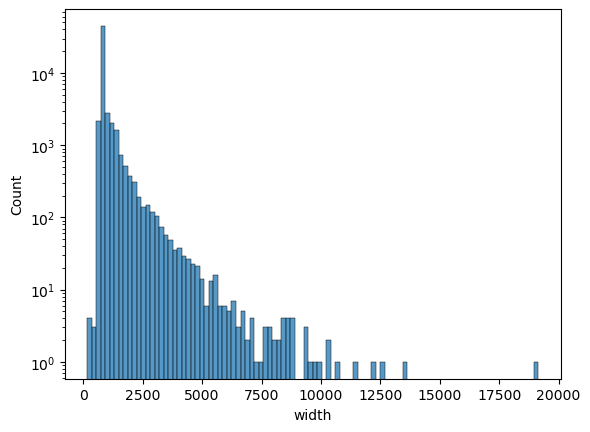

In [100]:
print(f"Found {len(peaks)} clusters")
fig = sns.histplot(data=peaks, x="width", bins=100)
fig.set(yscale="log")

In [101]:
def label_peaks(df):

	df = pr.PyRanges(df)

	# add rmsk and knrgl labels
	df_rmsk = df.overlap(rmsk).df.set_index(["Chromosome", "Start", "End"])
	df_knrgl = df.overlap(knrgl).df.set_index(["Chromosome", "Start", "End"])
	rmsk_covered = len(rmsk.overlap(df))
	knrgl_covered = len(knrgl.overlap(df))

	df = df.df.set_index(["Chromosome", "Start", "End"])
	df["rmsk"] = df.index.isin(df_rmsk.index)
	df["knrgl"] = df.index.isin(df_knrgl.index)
	df["label"] = df.apply(lambda x: "knrgl" if x.knrgl else "rmsk" if x.rmsk else "other", axis=1)

	knrgl_peaks = sum(df["label"] == "knrgl")
	rmsk_peaks = sum(df["label"] == "rmsk")
	
	print(f"{rmsk_peaks} peaks covering {rmsk_covered}/{len(rmsk)} rmsk L1 annotations")
	print(f"{knrgl_peaks} peaks covering {knrgl_covered}/{len(knrgl)} knrgl L1 annotations")

	# plot
	fig = sns.JointGrid(data=df.reset_index(), x="width", y="nreads", hue="label", marginal_ticks=True, hue_order=["other","rmsk","knrgl"])
	fig.plot_joint(sns.scatterplot, alpha = 0.5)
	fig.ax_joint.set(yscale = "log")

	fig.plot_marginals(sns.histplot, bins=100, element="step", fill=False)
	fig.ax_marg_x.set(yscale = "log")
	fig.ax_marg_y.set(xscale = "log")
	fig.ax_joint.set(xlabel = "Peak width (bp)", ylabel = "Number of reads")
	plt.show()

	return df

9497 peaks covering 10423/264879 rmsk L1 annotations
197 peaks covering 137/267 knrgl L1 annotations


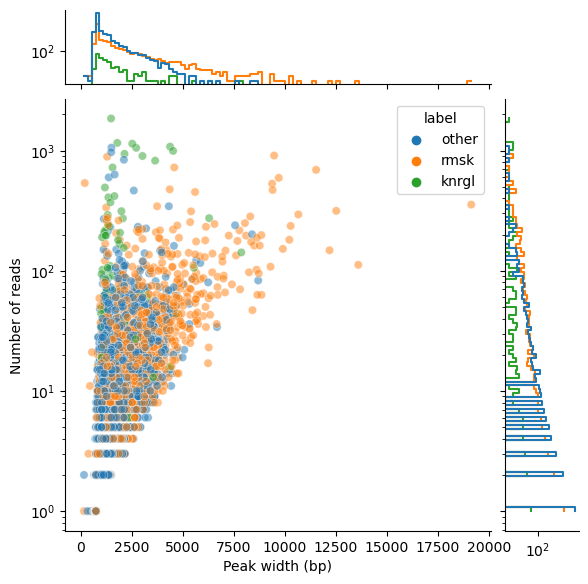

Cluster Strand  nreads  width   rmsk  knrgl  \
Chromosome Start    End                                                     
chr1       1813127  1813877         1      +       1    750  False  False   
           4063787  4064535         2      +       2    748  False  False   
           4198578  4199328         3      +       1    750  False  False   
           4200867  4201616         4      +       2    749  False  False   
           4209002  4209743         5      +       1    741  False  False   
...                               ...    ...     ...    ...    ...    ...   
chrY       21204894 21205644    56514      -       1    750   True  False   
           21260269 21261019    56515      -       1    750  False  False   
           21267260 21268389    56516      -       2   1129  False  False   
           21281111 21281861    56517      -       1    750  False  False   
           26581944 26582694    56518      -       1    750   True  False   

                              label  
Chromosome Start    End              
chr1       1813127  1813877   other  
           4063787  4064535   other  
           4198578  4199328   other  
           4200867  4201616   other  
           4209002  4209743   other  
...                             ...  
chrY       21204894 21205644   rmsk  
           21260269 21261019  other  
           21267260 21268389  other  
           21281111 21281861  other  
           26581944 26582694   rmsk  

[56518 rows x 7 columns]

In [102]:
label_peaks(peaks)

In [8]:
# STEP 2: gather additional features for each peak
print("Gathering other reads at these peaks...")
bam = pysam.AlignmentFile(snakemake.input.bam, "rb")  
for p in peaks:
    for r in bam.fetch(p.chr, p.start, p.end):
        if not r.is_unmapped:
            p.add_read(r)

bam.close()
df = visualize_peaks(peaks)

Gathering other reads at these peaks...


In [9]:
%%time

# from https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

# STEP 3: merge peaks that are close together
print("Merging peaks that are close together...")
for i, p in enumerate(peaks):
	if i > 0 and p.chr == peaks[i-1].chr:
		if gini(p.coverage) < gini(p.merge(peaks[i-1]).coverage): # TODO save p.merge and use that, dont call merge twice
			p = p.merge(peaks[i-1])
			peaks[i-1] = None

new_peaks = []
for p in peaks:
	if p is not None:
		new_peaks.append(p)

print(f"{len(new_peaks)} remain after merging")
df = visualize_peaks(new_peaks)


76003